In [1]:
%config Completer.use_jedi = False

In [2]:
import os
import sys
import re
from collections import defaultdict

import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns

# EDA

데이터 featrue 확인하기

In [3]:
df = pd.read_csv("./train/train.csv")

In [4]:
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [5]:
df.describe()

,age
count,2700.000000
mean,37.708148
std,16.985904
min,18.000000
25%,20.000000
50%,36.000000
75%,55.000000
max,60.000000


In [6]:
df.describe(include = ['O'])

,id,gender,race,path
count,2700,2700,2700,2700
unique,2699,2,1,2700
top,003397,female,Asian,004455_female_Asian_55
freq,2,1658,2700,1


## 데이터 개요

### train.csv 의 features
1. id
2. gender
3. race
4. age
5. path

### path에 들어있는 이미지의 features
1. mask 1 ~ 5
2. normal
3. incorrect

In [7]:
!tree -L 2

.
├── AE_latent_classifier.ipynb
├── EDA.ipynb
├── README.md
├── backbone_EDA.ipynb
├── datapath_with_label.csv
├── dataset.ipynb
├── eval
│   ├── images
│   └── info.csv
├── train
│   ├── images
│   └── train.csv
└── train.tar.gz

4 directories, 9 files


## 이미지 데이터
### 데이터 맛보기

이미지 데이터는 개인 1명의 폴더에 7장의 이미지가 들어있고 이 이미지들은 각각  

- 마스크를 잘 착용한 상태 5장
- 마스크를 잘못 착용한 상태 1장
- 마스크를 착용하지 않은 상태 1장  

이렇게 나눌 수 있다.

임의의 순번에 해당하는 이미지를 나열해보면 아래와 같다.


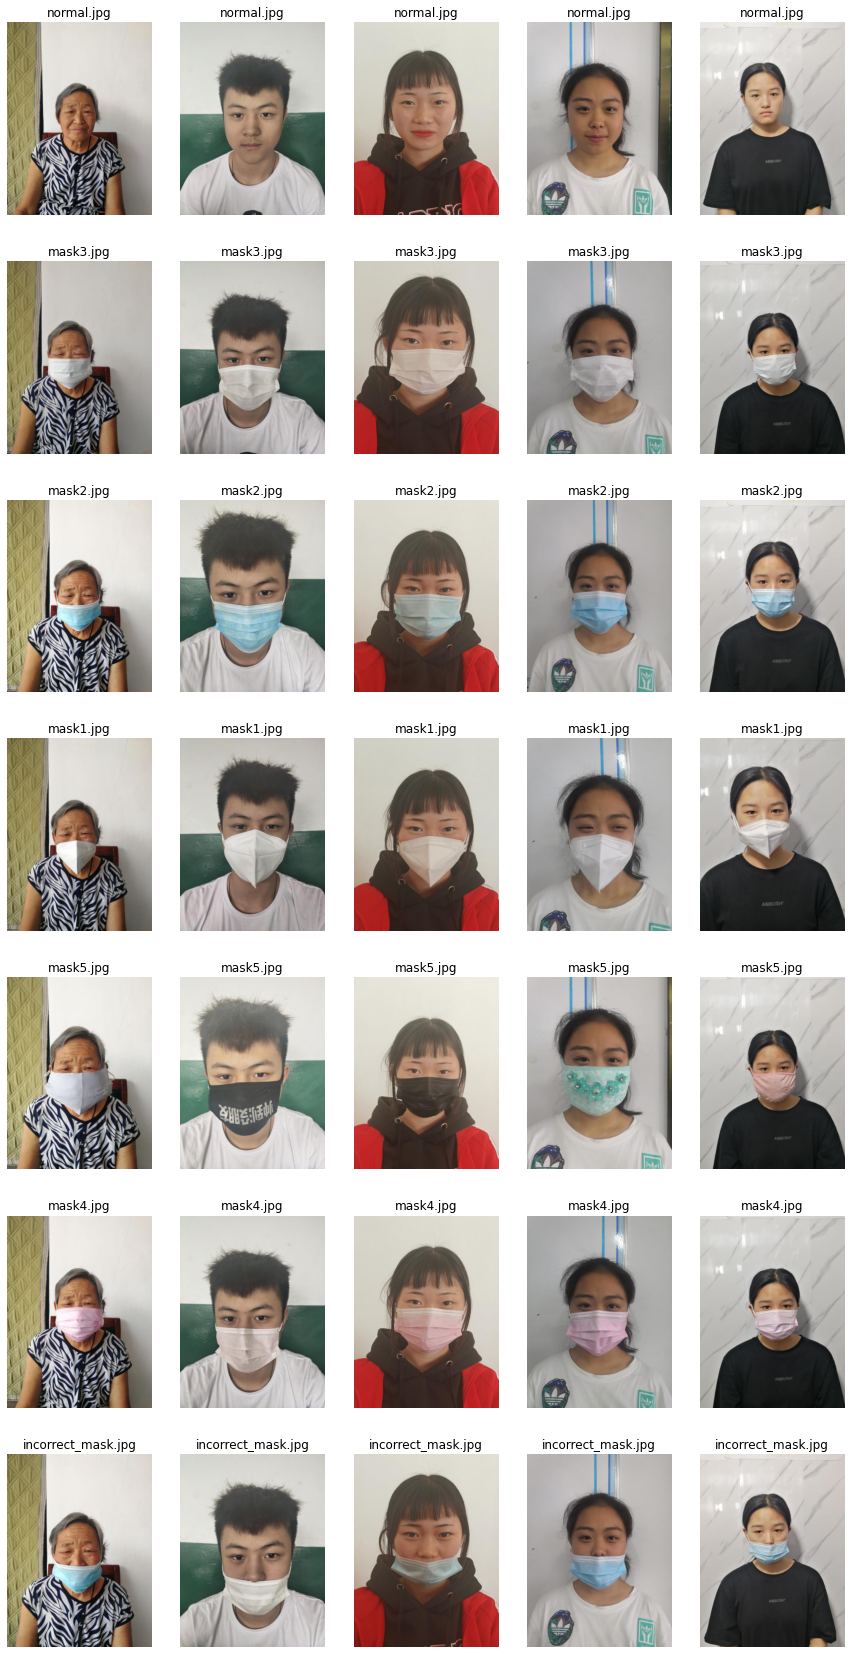

In [8]:
N = 5

fig, ax = plt.subplots(7,N)
fig.set_figheight(30)
fig.set_figwidth(15)

for j, n in enumerate(np.random.randint(0,len(df),size = N)):
    path = "./train/images/" + df["path"][n]
    i = 0
    for im_name in os.listdir(path):
        if not im_name.startswith("."):
            im = Image.open(path + '/' + im_name)

            ax[i][j].set_title(im_name)
            ax[i][j].imshow(im)
            ax[i][j].axis("off")
            i += 1
        
plt.show()

이미지를 직접보면 마스크 대신 손수건을 두른 사람도 있고 코나 눈에 마스크를 쓴 사람도 있다. 손수건으로 `눈과 입을 완전히 가린 사람`은 마스크를 잘 쓴 것과 동일한 라벨이 붙었고 `코끝이 보이는 사람`이나 `턱선이 보이는 사람`은 마스크를 잘못 쓴 것으로 분류되어 있다. 따라서 이미지를 잘라낼때는 반드시 턱선이 포함되도록 잘라야한다. 코끝이 살짝밖에 안 보이는 사람도 incorrect 로 분류가 되었는데 이런건 노이즈로 봐야할 것 같다.

### 이미지 한장당 크기

In [9]:
image_size = im.size # (384, 512)

이미지 1장의 크기는 384, 512 이다. 모든 이미지가 같은 크기인지 알아보자.

In [10]:
size_check = True
for n in range(len(df)):
    path = "./train/images/" + df["path"][n]
    for im_name in os.listdir(path):
        if not im_name.startswith("."):
            im = Image.open(path + '/' + im_name)
            size_check = (size_check and (im.size == image_size))
print("All images have the same size ::: ", size_check)

All images have the same size :::  True


모든 이미지의 크기는 같다.

### 이미지의 파일 확장자

파일확장자는 이미지마다 다를 수 있으므로 확인하도록 한다.

In [11]:
formats = defaultdict(int)
for n in range(len(df)):
    path = "./train/images/" + df["path"][n]
    for im_name in os.listdir(path):
        if not im_name.startswith("."):
            formats[re.sub("normal|mask[12345]|incorrect_mask","",im_name)] += 1
formats

defaultdict(int, {'.jpg': 18035, '.png': 511, '.jpeg': 354})

파일 확장자는 jpeg, jpg, png 세가지로 나타났다. jpeg가 가장 많다.
- [여기](https://www.keycdn.com/support/difference-between-jpg-and-jpeg#:~:text=There%20are%20actually%20no%20differences,extension%20for%20the%20file%20names)에 의하면 jpg와 jpeg는 같은 확장자라고 한다.
- [pillow_공식문서](https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html)에 따르면 jpeg와 png를 모두 pillow에서 정상적으로 사용할 수 있다고 한다.

그러므로 딱히 전처리 할 일은 없다.

In [12]:
num_of_total_data = sum(formats.values())
print(num_of_total_data,":::",num_of_total_data/len(df))

18900 ::: 7.0


모든 사람은 동일하게 7장의 사진을 찍었다. 누락된 데이터는 없다.

### 이미지 크롭 위치
이미지 다 더해서 평균을 내보면 대략 어디가 얼굴이고 마스크인지 알 수 있을것이다.

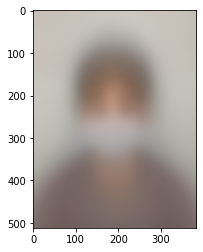

In [13]:
im_avg = np.zeros((512,384,3),dtype = np.float32)
for n in range(len(df)):
    path = "./train/images/" + df["path"][n]
    for im_name in os.listdir(path):
        if not im_name.startswith("."):
            im_avg += np.array(Image.open(path + '/' + im_name),dtype = np.float32)/225
            
im_avg = im_avg/(len(df)*7)
fig, ax = plt.subplots(1,1, figsize = (6, 4))
ax.imshow(im_avg)

plt.show()

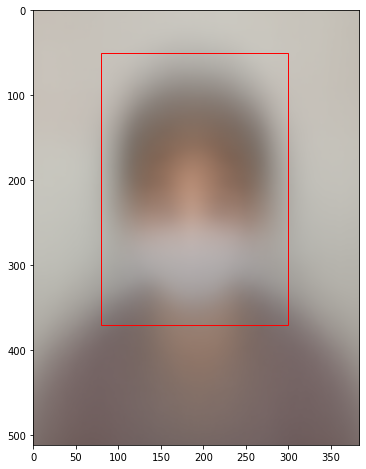

In [17]:
# https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image

x_1, y_1 = 100, 100
x_2, y_2 = 300, 400

fig, ax = plt.subplots(1,1, figsize = (12, 8))

ax.imshow(im_avg)

# Create a Rectangle patch
rect = patches.Rectangle(
    xy       = (80, 50),
    width    = 220,
    height   = 320,
    linewidth= 1,
    edgecolor= 'r',
    facecolor= 'none'
)

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

평균 이미지에 대한 좌표에 따르면
- (70, 40) 
- (70 + 240, 40)
- (70, 40 + 350)
- (70 + 240, 40 + 350)

네개의 꼭지점을 가지는 박스로 bounding 했을때 가장 효과적으로 잘라낼 수 있다.

## 라벨 구성

본 문제의 라벨은 3가지 기존의 라벨을 한데 묶어 만들어진 복합 라벨이다. 라벨은 3가지로 구성된다.  

1. 마스크의 착용 여부 (3가지)
2. 성별 (2가지)
3. 나이 대 (3가지)

이렇게 18개의 라벨을 달아야 하는데 각각을 따로 추론하는 것도 가능하다.
따라데 각각의 데이터가 얼마나 불균형한지 한번 보아야 한다.
마스크 착용 여부는 기본적으로 1:1:5의 차이가 난다. 한사람당 normal을 1장, mask1~5를 각 1장, incorrect_mask를 1장 찍었기 때문이다. 따라서 나이대와 성별의 격차만 보면 된다.

In [15]:
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [16]:
df["gender_num"] = df["gender"]
df.head()

,id,gender,race,age,path,gender_num
0,000001,female,Asian,45,000001_female_Asian_45,female
1,000002,female,Asian,52,000002_female_Asian_52,female
2,000004,male,Asian,54,000004_male_Asian_54,male
3,000005,female,Asian,58,000005_female_Asian_58,female
4,000006,female,Asian,59,000006_female_Asian_59,female


In [17]:
df["gender_num"] = df["gender_num"].map({"female" : 0, "male" : 1})
df.head()

,id,gender,race,age,path,gender_num
0,000001,female,Asian,45,000001_female_Asian_45,0
1,000002,female,Asian,52,000002_female_Asian_52,0
2,000004,male,Asian,54,000004_male_Asian_54,1
3,000005,female,Asian,58,000005_female_Asian_58,0
4,000006,female,Asian,59,000006_female_Asian_59,0


In [18]:
gender_count = df.groupby("gender_num").count()["id"]
gender_count

gender_num
0    1658
1    1042
Name: id, dtype: int64

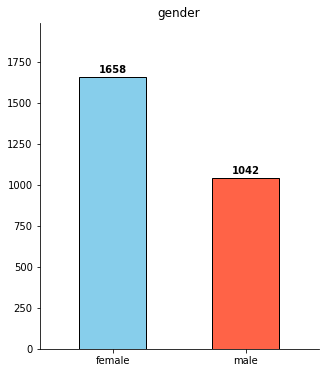

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (5,6))

ax.bar(
    gender_count.index,
    gender_count,
    width = 0.5,
    edgecolor = "black",
    color = ["skyblue","tomato"]
)

ax.set_xticks(gender_count.index)
ax.set_xticklabels(["female", "male"])
ax.margins(0.2, 0.2)
ax.set_title("gender")
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)

for idx, value in zip(gender_count.index, gender_count):
    
    ax.text(
        idx,
        value + 30,
        s = value,
        ha = 'center',
        fontweight = 'bold'
    )

성별로 보았을때 female이 male 보다 1.5배 정도 많다. 학습이 잘 이루어 지지 않는 다면 female의 수를 제한해서 1 대 1로 만드는 방법이 적절해 보인다.

In [20]:
df["age_band"] = None
df.loc[(df["age"] < 30),"age_band"] = "< 30"
df.loc[(df["age"] >= 30)&(df["age"] < 60),"age_band"] = ">= 30 and < 60"
df.loc[(df["age"] >= 60),"age_band"] = ">= 60"
df

,id,gender,race,age,path,gender_num,age_band
0,000001,female,Asian,45,000001_female_Asian_45,0,>= 30 and < 60
1,000002,female,Asian,52,000002_female_Asian_52,0,>= 30 and < 60
2,000004,male,Asian,54,000004_male_Asian_54,1,>= 30 and < 60
3,000005,female,Asian,58,000005_female_Asian_58,0,>= 30 and < 60
4,000006,female,Asian,59,000006_female_Asian_59,0,>= 30 and < 60
...,...,...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19,1,< 30
2696,006955,male,Asian,19,006955_male_Asian_19,1,< 30
2697,006956,male,Asian,19,006956_male_Asian_19,1,< 30
2698,006957,male,Asian,20,006957_male_Asian_20,1,< 30


In [21]:
age_band_count = df.groupby("age_band").count()["id"]
age_band_count

age_band
< 30              1281
>= 30 and < 60    1227
>= 60              192
Name: id, dtype: int64

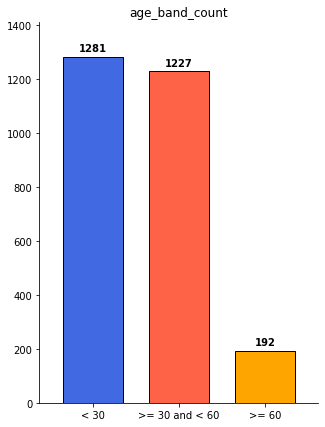

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (5,7))

ax.bar(
    age_band_count.index,
    age_band_count,
    width = 0.7,
    color = ["royalblue","tomato","orange"],
    edgecolor = "black"
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.margins(0.1,0.1)

ax.set_title("age_band_count")

for idx, value in zip(age_band_count.index, age_band_count):
    ax.text(
        idx,
        value + 20,
        s = value,
        ha = "center",
        fontweight = "bold"
    )

plt.show()

나이를 비교해 봤을때 60세 이상의 수가 현저히 적다. 이 경우 60세 이상의 나이를 예측하지 못할 가능성이 크다. 60세 이하의 데이터들을 많이 포기하더라도 적은 수의 데이터를 가지고 갈지 아니면 완전히 독특한 전략을 구상할지 계획이 필요하다.

## summary

1. 마스크
  - 바르게 씀 : 이상하게 씀 : 안씀 = 5 : 1 : 1
  - 이상하게 씀 : 코 끝이 보임, 턱선이 보임, 눈에 씀 입이 보임, 코에 씀 등등 다양
  - 전략 : 분류모델, anomaly detection 후 분류모델
2. 성별
  - 여성 : 남성 = 1.5 : 1
  - 비율이나 불균형이 크게 문제가 될 수준은 아님
  - 하지만 학습이 잘 안될 경우 1 : 1로 sub sample하여 훈련할 것
  - 전략 : 분류모델
3. 나이
  - [0,30) : [30,60) : [60,~) = 13 : 12 : 2
  - 60대 인가 아닌가의 차이가 극명하게 남
  - 다른 두 세대는 차이다 크게 나지 않음
  - 전략 : anomaly detection 이후 분류, subsample 분류